# Organelle image classification

In [61]:
# Loading packages
import numpy as np
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision import models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torchinfo import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# TODO

1. efficientnetv2
2. Introduce regularization techniques like dropout or batch normalization to prevent overfitting. Dropout layers can help reduce interdependency among neurons by randomly dropping some during training. Batch normalization helps in stabilizing and accelerating the training process.
3. over/undersampling
4. show batch, show NN architecture

## 1. Introduction

This project aims to reach protein classification through advanced image analysis techniques. The primary objective is to create a machine learning model capable of predicting the presence of specific proteins within a given image, addressing the complexity of a multi-label classification challenge. The metric of choice for assessing model performance is the mean F1-score, ensuring precision and recall are both accounted for.

## 2. Loading the data

In [62]:
# Paths
train_data_dir = "./train"
train_csv = "./train.csv"

test_data_dir = "./test"
test_csv = "./sub.csv"

In [63]:
# Load the csv file containing the train labels
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [94]:
# Prepare the label dictionary
labels = {
    0: "Mitochondria",
    1: "Nuclear bodies",
    2: "Nucleoli",
    3: "Golgi apparatus",
    4: "Nucleoplasm",
    5: "Nucleoli fibrillar center",
    6: "Cytosol",
    7: "Plasma membrane",
    8: "Centrosome",
    9: "Nuclear speckles",
}

# 3. Data exploration

In [65]:
display(train_df.head())

,Image,Label
0,12874,1 4
1,21466,0
2,3610,4
3,2095,2 4
4,28909,4


The labels are correctly loaded as a dataframe, each image has a series of associated labels, delimited by spaces.

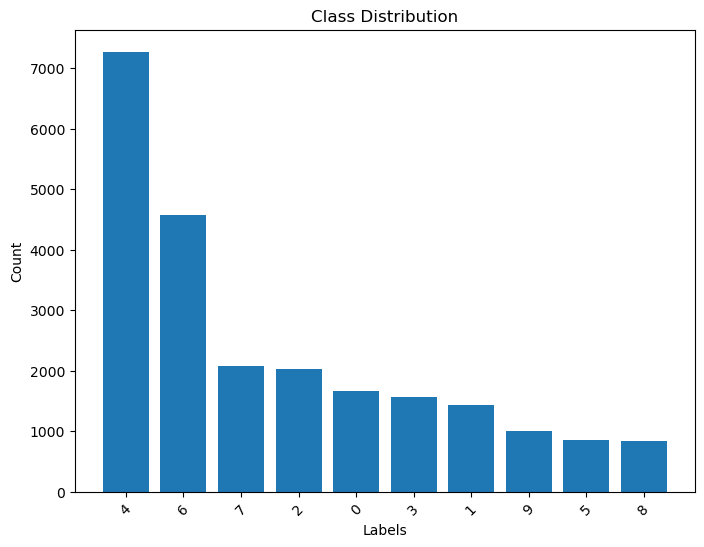

In [98]:
# Check class distribution

label_counts = {}
flat_label_list =[]
for values in train_df['Label']:
    label_list = values.split()
    for label in label_list:
        flat_label_list.append(label)
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1


sorted_label_counts = {k: v for k, v in sorted(label_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(8, 6))
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())
plt.title('Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

There is noticable class imbalance, 4 and 6 (Golgi apparatus, Nucleoplasm) have a much larger occurrence than the other classes.

SOLUTIONS:
1) Weights will be calculated and a weighted loss function will be used that assigns higher weights to minority class samples during training.
2) Oversampling- and undersampling techniques help to handle imbalanced classes effectively.

In [102]:
# Extract unique labels from the dataset
unique_labels = set(str(key) for key in labels.keys())
unique_labels = sorted(list(unique_labels))

class_weights = compute_class_weight('balanced', classes=unique_labels, y=  flat_label_list)
weights_dict = {i:class_weights[i] for i in range(10)}
print("Class weights:", weights_dict)

Class weights: {0: 1.3986194477791116, 1: 1.6294405594405594, 2: 1.1506666666666667, 3: 1.4936538461538462, 4: 0.3203767358724048, 5: 2.7125727590221187, 6: 0.5094228246611281, 7: 1.1251086431675519, 8: 2.787200956937799, 9: 2.3139026812313803}


As we can see, more abundant classes 4 and 6 now carry lower weights.

In [14]:
# Explore image characteristics
sample_image = Image.open('./train/0.png')

print("Sample Image Information:")
print(f"Image Size: {sample_image.size}")
print(f"Image Mode: {sample_image.mode}")

Sample Image Information:
Image Size: (128, 128)
Image Mode: RGB


In [15]:
# Check for missing values in the dataset
missing_labels = train_df['Label'].isnull().sum()
print("Number of missing labels:", missing_labels)

Number of missing labels: 0


# 4. Preprocessing

In [16]:
# Since we have a multi-label classification problem, images can have more than 1 label. In order to transform the labels to a tensor that can be used for training, we can encode them to the format of a tensor, using a one-hot-encoding.
def encode_label(label: str):
    # create tensor of length 10 for the one-hot-ecoding
    target = torch.zeros(10)
    # now iterate over the classes in the string and set the respective 0's to 1's
    for l in str(label).split(" "):
        target[int(l)] = 1.0
    return target

In [17]:
# function to decode the encoded labels back to its original format
def decode_target(
    target: torch.Tensor, text_labels: bool = False, threshold: float = 0.5
):
    result = []
    for i, x in enumerate(target):
        if x >= threshold:
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return " ".join(result)

In [18]:
# To normalize the data, we need to calculate the means and stdevs per channel for the images

# Initialize lists to store channel-wise mean and standard deviation
mean_per_channel = [0.0, 0.0, 0.0]
std_per_channel = [0.0, 0.0, 0.0]

# Iterate over all images in the dataset directory
count = 0
for filename in os.listdir(train_data_dir):
    img = Image.open(os.path.join(train_data_dir, filename))
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    
    # Calculate per-channel mean
    mean_per_channel[0] += np.mean(img[:, :, 0])
    mean_per_channel[1] += np.mean(img[:, :, 1])
    mean_per_channel[2] += np.mean(img[:, :, 2])
    
    # Calculate per-channel standard deviation
    std_per_channel[0] += np.std(img[:, :, 0])
    std_per_channel[1] += np.std(img[:, :, 1])
    std_per_channel[2] += np.std(img[:, :, 2])
    
    count += 1

# Calculate the mean and standard deviation across all images
total_images = len(os.listdir(train_data_dir))
mean_per_channel = [m / total_images for m in mean_per_channel]
std_per_channel = [s / total_images for s in std_per_channel]

print("Mean per channel:", mean_per_channel)
print("Standard deviation per channel:", std_per_channel)

Mean per channel: [0.07819786874680719, 0.05209000149719703, 0.05402339364832606]
Standard deviation per channel: [0.11591775167397261, 0.07654528936568694, 0.13421668103375917]


We are not dealing with everyday images but fluorescence microscopy. In these images, the RGB values behave different than regular. We will normalize the values based on the means and stdevs per channel.

# 5. Convolutional Neural Networks

In [19]:
# We can create a PyTorchDataset that will ease the training process and can be used later for the DataLoader:


class ProteinDataset(Dataset):
    def __init__(self, dataframe, data_dir='./train', transform=None, mode='train'):
        self.data = dataframe
        self.transform = transform
        self.data_dir = data_dir
        self.mode = mode  # 'train' or 'test'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mode == 'train':
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + '.png')
            image = Image.open(img_name)
            label = encode_label(self.data.iloc[idx, 1])

            if self.transform:
                image = self.transform(image)

            return image, label
        elif self.mode == 'test':
            img_name = os.path.join(self.data_dir, str(self.data.iloc[idx, 0]) + '.png')
            image = Image.open(img_name)

            if self.transform:
                image = self.transform(image)

            return image, self.data.iloc[idx, 0]  # Return image name for test mode
        else:
            raise ValueError("Invalid mode. Use 'train' or 'test'.")

In [20]:
# Transformations
transforms_train = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels if needed
    #transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    #transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_per_channel, std=std_per_channel)
])

- Rotations and horizontal/vertical flips don't affect performance as the histological slides are not fixated in a certain orientation before imaging. All organelles are represented in a random rotation already.
- Cropping is unnecesary as the images are focused on the organelles of interest. There is no background noise to remove.
# - random flips for increating variation --> reduces overfitting

In [21]:
train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size

train_dataset, val_dataset = train_test_split(train_df, test_size=val_size)

train_loader = DataLoader(ProteinDataset(train_dataset, transform=transforms_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ProteinDataset(val_dataset, transform=transforms_train), batch_size=32, shuffle=False)

In [22]:
# Convert class_weights dictionary to a tensor
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float)

## 5.1 Custom CNN

In [ ]:
class ProteinCNN(nn.Module):
    def __init__(self):
        super(ProteinCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            32 * 32 * 32, 256
        )
        self.fc2 = nn.Linear(
            256, 10
        )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(
            -1, 32 * 32 * 32
        )
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = ProteinCNN()

criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor) # take into account the class_weights to battle the class imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float()).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')

## 5.2 TINYVGG

In [ ]:
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        # Adjusted linear layer based on the output size after the final pooling
        self.fc1 = nn.Linear(128 * 4 * 4, 32)  # Change to 32
        self.fc2 = nn.Linear(32, 10)  # 10 output classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        # Ensure the output size matches the expected label size
        x = x.view(-1, 128 * 4 * 4)  # Adjust the shape to match the flattened output size
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# Initialize the TinyVGG model
model = TinyVGG()


# Define the loss function (BCEWithLogitsLoss) and the optimizer
criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float()).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')

We are not dealing with everyday images but fluorescence microscopy. In these images, the RGB values behave different than regular. We will normalize the values based on the means and stdevs per channel.

## 5.4 wtf

In [28]:
class ProteinTinyVGG(nn.Module):
    def __init__(self):
        super(ProteinTinyVGG, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(
            64 * 8 * 8, 256
        )
        self.fc2 = nn.Linear(
            256, 10
        )

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout with probability 0.5

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.dropout(x)  # Apply dropout after the activation function
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.dropout(x)  # Apply dropout after the activation function
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
# Initialize the TinyVGG model
model = ProteinTinyVGG()


# Define the loss function (BCEWithLogitsLoss) and the optimizer
criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels.float()).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')

Epoch 1/10, Training Loss: 0.4631205511557591, Validation Loss: 0.5215137155400109
Epoch 2/10, Training Loss: 0.4377297099534567, Validation Loss: 0.4609956019317981
Epoch 3/10, Training Loss: 0.4215284309603951, Validation Loss: 0.4379791933851144
Epoch 4/10, Training Loss: 0.4068453297986613, Validation Loss: 0.4323867107789541
Epoch 5/10, Training Loss: 0.3934876713659856, Validation Loss: 0.40320543898749595
Epoch 6/10, Training Loss: 0.38434632366353816, Validation Loss: 0.3851793939919816
Epoch 7/10, Training Loss: 0.37415660867443334, Validation Loss: 0.38320785484363123
Epoch 8/10, Training Loss: 0.36380992547258156, Validation Loss: 0.36662522388487745
Epoch 9/10, Training Loss: 0.3564735824798609, Validation Loss: 0.38642563340590175
Epoch 10/10, Training Loss: 0.3443231653857541, Validation Loss: 0.3613057234852584
Finished Training


In [ ]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    print(labels.size())
    outputs = model(inputs)
    print(outputs.size())
    break

## 5.4 RESNET-50

In [ ]:

# Preprocess the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet-50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.07819786874680719, 0.05209000149719703, 0.05402339364832606],
                         std=[0.11591775167397261, 0.07654528936568694, 0.13421668103375917])
])


train_size = int(0.8 * len(train_df))
val_size = len(train_df) - train_size

train_dataset, val_dataset = train_test_split(train_df, test_size=val_size)

train_loader = DataLoader(ProteinDataset(train_dataset, transform=transform), batch_size=32, shuffle=True)
val_loader = DataLoader(ProteinDataset(val_dataset, transform=transform), batch_size=32, shuffle=False)

# Initialize the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Freeze all the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function, optimizer, and learning rate
criterion = nn.BCEWithLogitsLoss()  # Assuming you're using a binary cross-entropy loss for multi-label classification
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}")

# Evaluate the model
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Apply threshold to convert probabilities to binary predictions
        threshold = 0.5
        predicted = (outputs > threshold).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


In [ ]:
# Evaluate the model
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Apply threshold to convert probabilities to binary predictions
        threshold = 0.5
        predicted = (outputs > threshold).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for evaluation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

## 5.5 Densenet

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8331148/

In [37]:
import torchvision.models as models

# Define the model architecture using pre-trained DenseNet
class ProteinDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ProteinDenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        # Modify the last fully connected layer to output the number of classes
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # For multi-label classification
        )
# Densenet already has dropout layers so adding extra ones is unncessary
    def forward(self, x):
        return self.densenet(x)


In [38]:

# Initialize the model
model = ProteinDenseNet()


/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
summary(model)

Layer (type:depth-idx)                        Param #
ProteinDenseNet                               --
├─DenseNet: 1-1                               --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       9,408
│    │    └─BatchNorm2d: 3-2                  128
│    │    └─ReLU: 3-3                         --
│    │    └─MaxPool2d: 3-4                    --
│    │    └─_DenseBlock: 3-5                  335,040
│    │    └─_Transition: 3-6                  33,280
│    │    └─_DenseBlock: 3-7                  919,680
│    │    └─_Transition: 3-8                  132,096
│    │    └─_DenseBlock: 3-9                  2,837,760
│    │    └─_Transition: 3-10                 526,336
│    │    └─_DenseBlock: 3-11                 2,158,080
│    │    └─BatchNorm2d: 3-12                 2,048
│    └─Sequential: 2-2                        --
│    │    └─Linear: 3-13                      524,800
│    │    └─ReLU: 3-14                        --
│    │    └─Li

In [ ]:

# Define the criterion and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Assuming you have your data loaders set up as train_loader and val_loader

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')


# 6. Evaluation

In [34]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
threshold = 0.5  # Define a threshold for prediction

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        
        # Apply threshold to convert probabilities to binary predictions
        predicted = (outputs > threshold).float()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0) * labels.size(1)  # Total number of elements in the batch
        correct += (predicted == labels).sum().item()  # Count correct predictions

accuracy = correct / total
print(f"Accuracy on validation set: {accuracy}")

# Calculate precision, recall, and F1-score for each label separately
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Print or use the calculated scores as needed
print("Precision for each label:", precision)
print("Recall for each label:", recall)
print("F1-score for each label:", f1)

Accuracy on validation set: 0.9042884990253411
Precision for each label: [0.85148515 0.5        0.86666667 0.675      0.79534884 0.60824742
 0.6974026  0.71296296 0.62068966 0.71264368]
Recall for each label: [0.50439883 0.38095238 0.42523364 0.53289474 0.83240612 0.33146067
 0.60067114 0.36406619 0.20571429 0.3315508 ]
F1-score for each label: [0.6335175  0.43243243 0.57053292 0.59558824 0.81345566 0.42909091
 0.64543269 0.48200313 0.30901288 0.45255474]


# 7. Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64]
    # Add other hyperparameters to tune
}

# Define your model creation as a function
def create_model(lr, batch_size):
    model = ProteinTinyVGGWithDropout()  # Modify this line if using a different model
    criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

# Create an instance of the model
model = create_model()

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_weighted')

# Fit the model with the grid search
grid_search.fit(train_loader)

# Get the best parameters and their performance
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)


# 8. CSV file

In [42]:
# Predictions for the test set

test_dataset = ProteinDataset(test_df, data_dir=test_data_dir, transform=transforms_train, mode='test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [43]:
# Make predictions for the test images
model.eval()
predictions = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        outputs = model(inputs)
        
        # Apply threshold for binary predictions
        threshold = 0.5
        predicted = (outputs > threshold).squeeze().cpu().numpy().astype(int)
        
        # Convert predictions to label format
        predicted_labels = " ".join([str(i) for i in np.where(predicted == 1)[0]])

        # Append image names and predicted labels to list
        predictions.append((img_names[0].item(), predicted_labels))

# Write predictions to sub.csv
submission_df = pd.DataFrame(predictions, columns=["Image", "Label"])
submission_df.to_csv("sub.csv", index=False)

# ADDENDUM

In [40]:
# Saving model checkpoint
# Save the model state and optimizer state
torch.save({
    'epoch': num_epochs,  # Current epoch count
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # Add other necessary information
}, 'checkpoint.pth')  # Save the checkpoint


In [41]:
# additional training

# Load the model
model = ProteinDenseNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the checkpoint
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch'] + 1  # Start from the next epoch

# Continue training for additional epochs
num_epochs_to_continue = 4
for epoch in range(epoch_start, epoch_start + num_epochs_to_continue):
    model.train()
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}")

print('Finished Training')

/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mxvp/anaconda3/envs/ml_course_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 12/10, Training Loss: 0.221843211333473, Validation Loss: 0.2621154416467726
Epoch 13/10, Training Loss: 0.21818800022849788, Validation Loss: 0.24566869007557937
Epoch 14/10, Training Loss: 0.21435287223233804, Validation Loss: 0.24995970833547337
Epoch 15/10, Training Loss: 0.21023100651316828, Validation Loss: 0.24797847774839893
Finished Training


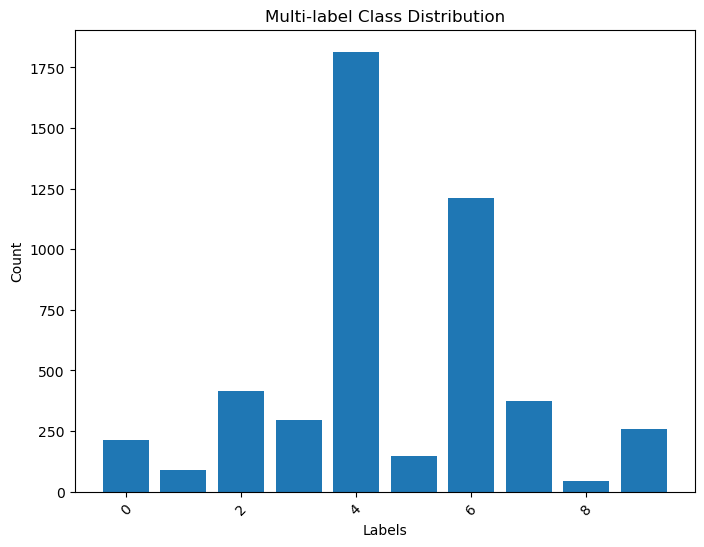

In [36]:
# Class distribution of predictions


filtered_df = test_df.dropna(subset=['Label'])
label_counts = {}
all_labels = filtered_df['Label'].str.split().explode()

for label in all_labels:
    label = int(label)
    if label in label_counts:
        label_counts[label] += 1
    else:
        label_counts[label] = 1

sorted_label_counts = {k: v for k, v in sorted(label_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(8, 6))
plt.bar(sorted_label_counts.keys(), sorted_label_counts.values())
plt.title('Multi-label Class Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()